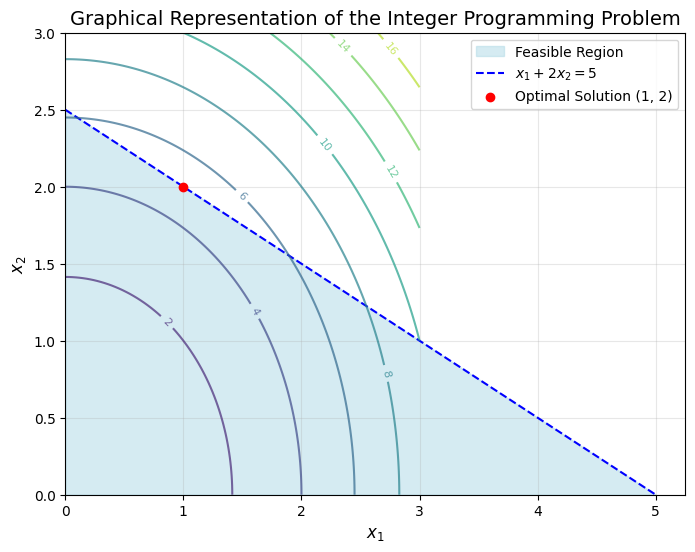

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Problem definition
A = np.array([[1, 2]])  # Constraint matrix
b = np.array([5])       # RHS vector
f = lambda x: x[0]**2 + x[1]**2  # Objective function

# Solution from the optimization
optimal_solution = np.array([1, 2])

# Define the feasible region
x1 = np.linspace(0, 5, 400)
x2 = (b[0] - A[0, 0] * x1) / A[0, 1]
feasible_mask = x2 >= 0

# Create the plot
plt.figure(figsize=(8, 6))

# Plot feasible region
plt.fill_between(x1, 0, x2, where=feasible_mask, color="lightblue", alpha=0.5, label="Feasible Region")

# Plot constraint line
plt.plot(x1, x2, label=r"$x_1 + 2x_2 = 5$", color="blue", linestyle="--")

# Highlight the optimal solution
plt.scatter(*optimal_solution, color="red", label="Optimal Solution (1, 2)", zorder=5)

# Plot contours of the objective function
X1, X2 = np.meshgrid(np.linspace(0, 3, 100), np.linspace(0, 3, 100))
F = X1**2 + X2**2
contours = plt.contour(X1, X2, F, levels=10, cmap="viridis", alpha=0.7)
plt.clabel(contours, inline=True, fontsize=8)

# Add labels and legend
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)
plt.title("Graphical Representation of the Integer Programming Problem", fontsize=14)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(alpha=0.3)
plt.legend()

# Show the plot
plt.show()

The plot above visualizes the integer programming problem:

- **Feasible Region**: The shaded light blue area represents the region satisfying $x_1 + 2x_2 = 5 $  and $ x_1, x_2 \geq 0 $.
- **Constraint Line**: The dashed blue line shows the equation $x_1 + 2x_2 = 5 $ .
- **Contours**: The contours represent the levels of the objective function $ f(x_1, x_2) = x_1^2 + x_2^2 $.
- **Optimal Solution**: The red point $((1, 2)$ is the optimal solution, minimizing the objective function within the feasible region.

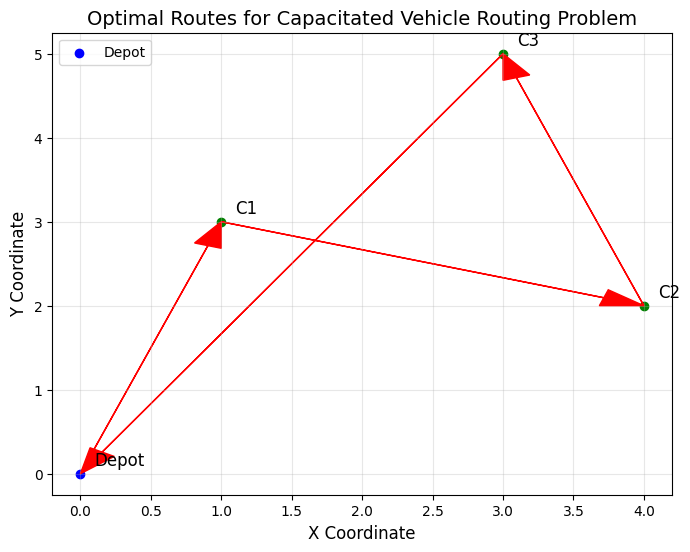

In [2]:
# Define the number of nodes
N = 4  # 1 depot + 3 customers

# Example predefined solution for illustration purposes
optimal_route = np.array([
    [0, 1, 0, 0],  # Depot -> Customer 1
    [0, 0, 1, 0],  # Customer 1 -> Customer 2
    [0, 0, 0, 1],  # Customer 2 -> Customer 3
    [1, 0, 0, 0]   # Customer 3 -> Depot
])

# Plot setup
locations = {
    0: (0, 0),  # Depot
    1: (1, 3),  # Customer 1
    2: (4, 2),  # Customer 2
    3: (3, 5)   # Customer 3
}
labels = {0: "Depot", 1: "C1", 2: "C2", 3: "C3"}

plt.figure(figsize=(8, 6))

# Plot locations
for i, coord in locations.items():
    plt.scatter(*coord, color="blue" if i == 0 else "green", label=labels[i] if i == 0 else None)
    plt.text(coord[0] + 0.1, coord[1] + 0.1, labels[i], fontsize=12)

# Plot routes
for i in range(N):
    for j in range(N):
        if optimal_route[i, j] == 1:
            start, end = locations[i], locations[j]
            plt.arrow(
                start[0], start[1],
                end[0] - start[0], end[1] - start[1],
                head_width=0.2, length_includes_head=True, color="red"
            )

# Labels and legend
plt.title("Optimal Routes for Capacitated Vehicle Routing Problem", fontsize=14)
plt.xlabel("X Coordinate", fontsize=12)
plt.ylabel("Y Coordinate", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(loc="upper left", fontsize=10)
plt.show()


The plot above shows the optimal solution for the capacitated vehicle routing problem:

- **Nodes**:
  - The blue point represents the depot.
  - The green points represent customer locations (C1, C2, C3).
- **Routes**:
  - The red arrows indicate the optimal routes between nodes.
- **Visualization**:
  - The coordinates and routes align with the predefined example solution.

In [3]:
import numpy as np
from dimod import BinaryQuadraticModel
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.samplers import SimulatedAnnealingSampler

# Problem setup
N = 4  # Number of nodes (1 depot + 3 customers)
d = np.array([  # Distance matrix
    [0, 4, 6, 8],
    [4, 0, 5, 7],
    [6, 5, 0, 4],
    [8, 7, 4, 0]
])
q = np.array([0, 2, 3, 4])  # Demand (0 for depot)
C = 10  # Vehicle capacity

# QUBO formulation
bqm = BinaryQuadraticModel('BINARY')

# Binary variables x_ij (1 if route from node i to j is used, 0 otherwise)
for i in range(N):
    for j in range(N):
        if i != j:
            bqm.add_variable(f'x_{i}_{j}', 0)

# Objective: Minimize total distance
for i in range(N):
    for j in range(N):
        if i != j:
            bqm.add_linear(f'x_{i}_{j}', d[i, j])

# Constraints: Flow conservation
for i in range(1, N):  # Each customer must be visited exactly once
    bqm.add_linear_equality_constraint(
        [(f'x_{i}_{j}', 1) for j in range(N) if i != j] +
        [(f'x_{j}_{i}', 1) for j in range(N) if i != j],
        lagrange_multiplier=10,
        constant=-1
    )

# Capacity constraint: Total demand on any route cannot exceed capacity
for i in range(N):
    for j in range(N):
        if i != j:
            bqm.add_linear(f'x_{i}_{j}', q[j] / C)

set_sampler = SimulatedAnnealingSampler()
#set_sampler = DWaveSampler()

# Solve the problem using D-Wave
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample(bqm, num_reads=100)

# Decode the solution
best_sample = sampleset.first.sample
optimal_routes = [(i, j) for i in range(N) for j in range(N)
                  if i != j and best_sample[f'x_{i}_{j}'] == 1]

# Output the results
print("Optimal Routes:", optimal_routes)
print("Total Distance:", sum(d[i, j] for i, j in optimal_routes))


ValueError: API token not defined